# Imports

In [1]:
from datetime import datetime
import pandas as pd

from diive.core.io.files import load_parquet, save_parquet
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS

# Load data

In [2]:
df = load_parquet(filepath="51.1_CH-CHA_IRGA-L4.1+QCL-L1+LGR-L1+M10+MGMT_2005-2023.parquet")
# df = df.loc[(df.index.year >= 2021) & (df.index.year <= 2023)].copy()
df

Loaded .parquet file 51.1_CH-CHA_IRGA-L4.1+QCL-L1+LGR-L1+M10+MGMT_2005-2023.parquet (0.831 seconds). Detected time resolution of <30 * Minutes> / 30min 


,AIR_MV,AIR_DENSITY,AIR_RHO_CP,AIR_CP,AOA_METHOD,AXES_ROTATION_METHOD,...,SWC_GF1_0.75_1,TS_GF1_0.04_1,TS_GF1_0.15_1,TS_GF1_0.4_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED,TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1
2005-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2
2005-01-01 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0
2005-01-01 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1
2005-01-01 02:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0.023667,1.22060,1231.56,1008.98,0.0,1.0,...,52.856753,3.359719,4.942291,6.010860,0.0,7
2023-12-31 22:15:00,0.023709,1.21833,1229.43,1009.11,0.0,1.0,...,52.826993,3.220912,4.944976,6.011540,0.0,8
2023-12-31 22:45:00,0.023718,1.21785,1228.93,1009.10,0.0,1.0,...,52.912827,3.148644,4.941619,6.014273,0.0,9


# Gap-filling `TS`

In [3]:
[print(c) for c in df if "TS_" in c];

TS_GF1_0.04_1
TS_GF1_0.15_1
TS_GF1_0.4_1


## Fill `TS_GF1_0.04_1`


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.

Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-09-09 10:15:00 and 2023-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:4.77052	validation_1-rmse:4.76020
[1]	validation_0-rmse:3.50090	validation_1-rmse:3.49467
[2]	validation_0-rmse:2.64395	validation_1-rmse:2.63903
[3]	validation_0-rmse:2.07689	validation_1-rmse:2.07342
[4]	validation_0-rmse:1.71222	validation_1-rmse:1.71113
[5]	validation_0-rmse:1.47852	validation_1-rmse:1.48005
[6]	validation_0-rmse:1.32504	validation_1-rmse:1.32654
[7]	validation_0-rmse:1.22426	validation_1-rmse:1.22694
[8]	validation_0-rmse:1.16396	validation_1-rmse:1.16817
[9]	validation_0-rmse:1.10056	validation_1-rmse:1.10533
[10]	va

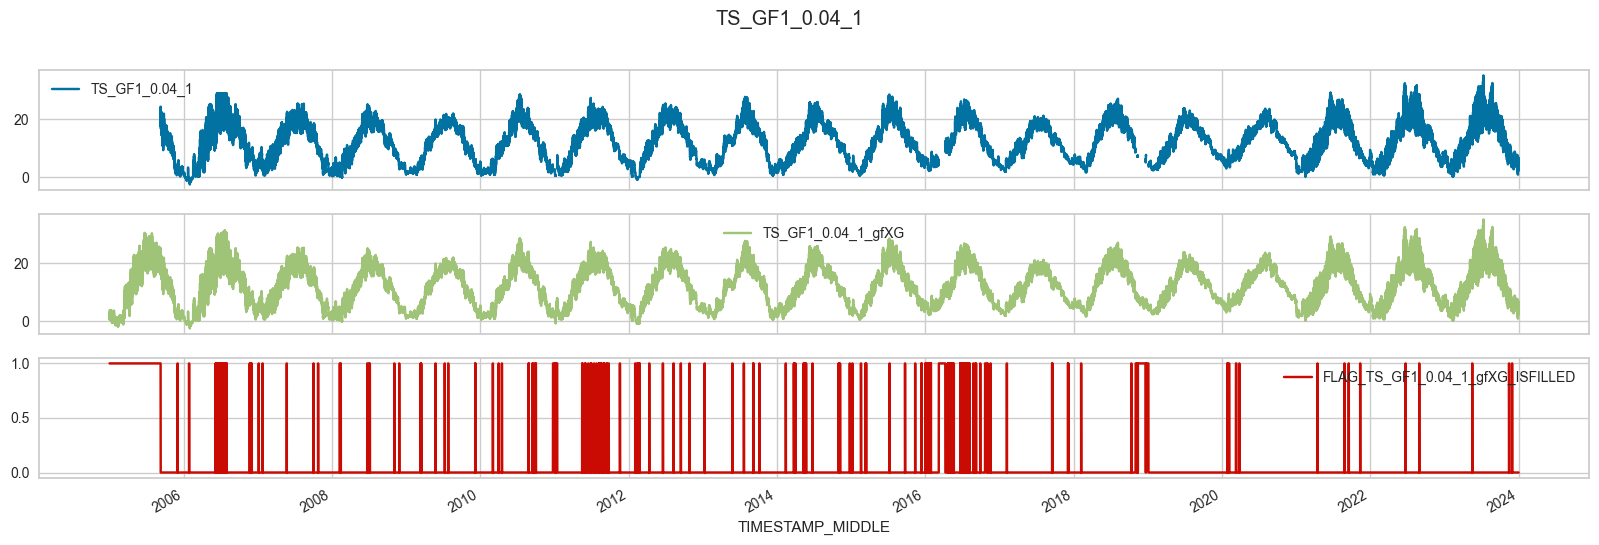

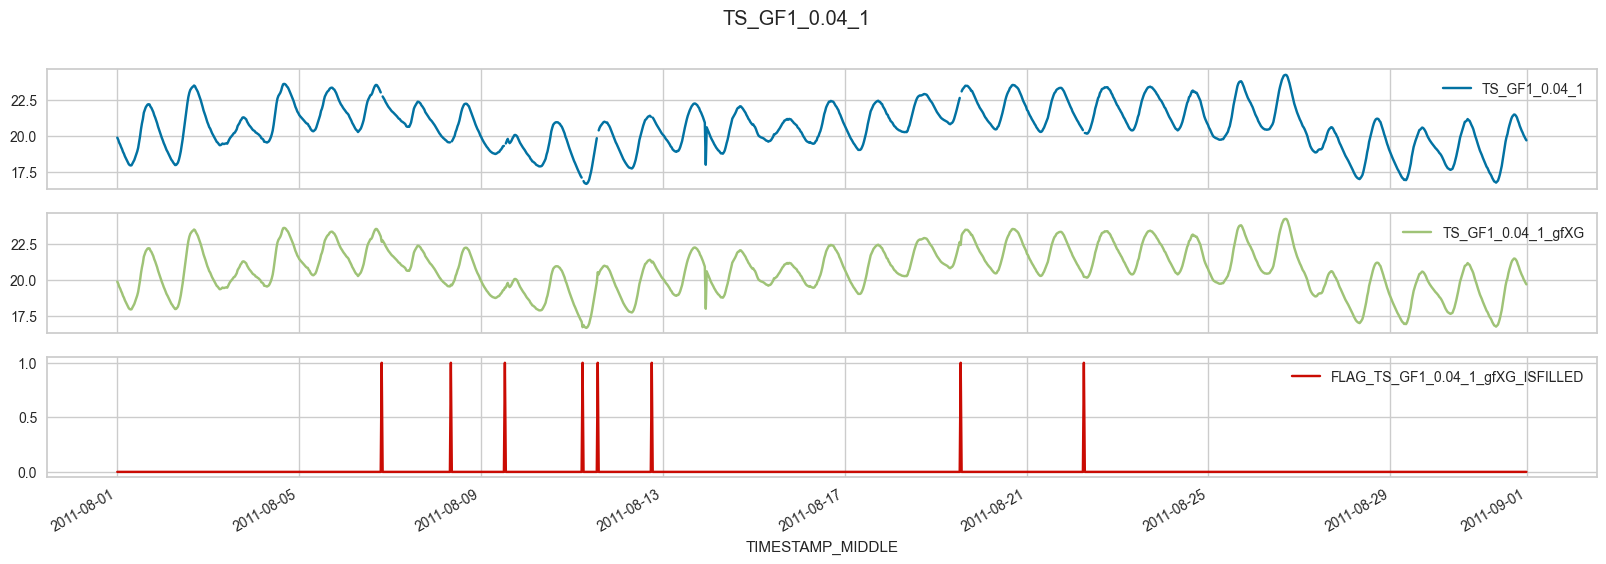

In [4]:
TARGET_COL = 'TS_GF1_0.04_1'
TARGET_GAPFILLED_COL = f'{TARGET_COL}_gfXG'
FLAG_GAPFILLED_COL = f'FLAG_{TARGET_GAPFILLED_COL}_ISFILLED'

# Dataframe for gap-filling
_df = pd.DataFrame()
_df[TARGET_COL] = df[TARGET_COL].copy()
_df['TA_T1_2_1'] = df['TA_T1_2_1'].copy()

# XGBoost
xgb = XGBoostTS(
    input_df=_df,
    target_col=TARGET_COL,
    features_lag=[-5, -1],
    features_lag_exclude_cols=None,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()
results = xgb.gapfilling_df_

# Add results to main data
df = pd.concat([df, results[[TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]]], axis=1)

# Plot
plotdf = df[[TARGET_COL, TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]].copy()
plotdf.plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));
locs = (plotdf.index.year == 2011) & (plotdf.index.month == 8)
plotdf[locs].plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));

## Fill `TS_GF1_0.15_1`


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.

Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-09-09 10:15:00 and 2023-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:4.38039	validation_1-rmse:4.37266
[1]	validation_0-rmse:3.10517	validation_1-rmse:3.09981
[2]	validation_0-rmse:2.21777	validation_1-rmse:2.21381
[3]	validation_0-rmse:1.60424	validation_1-rmse:1.60144
[4]	validation_0-rmse:1.18432	validation_1-rmse:1.18322
[5]	validation_0-rmse:0.90083	validation_1-rmse:0.90110
[6]	validation_0-rmse:0.71247	validation_1-rmse:0.71290
[7]	validation_0-rmse:0.58939	validation_1-rmse:0.59024
[8]	validation_0-rmse:0.51339	validation_1-rmse:0.51465
[9]	validation_0-rmse:0.46520	validation_1-rmse:0.46721
[10]	va

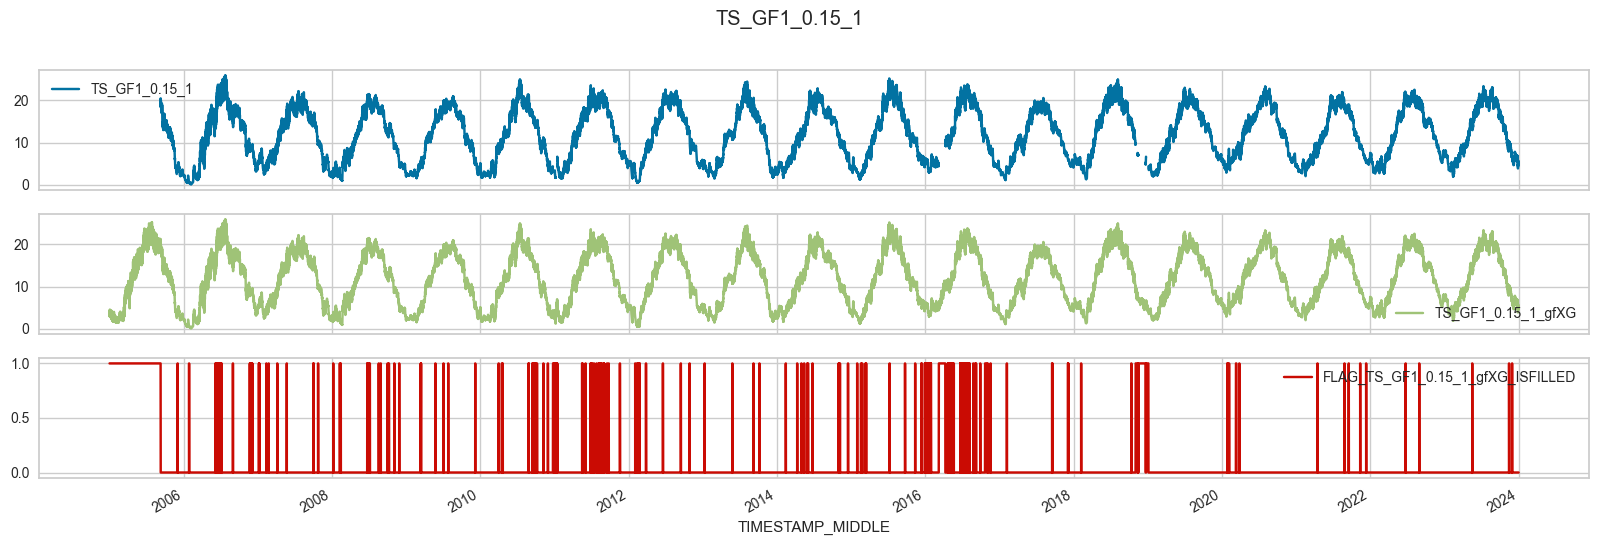

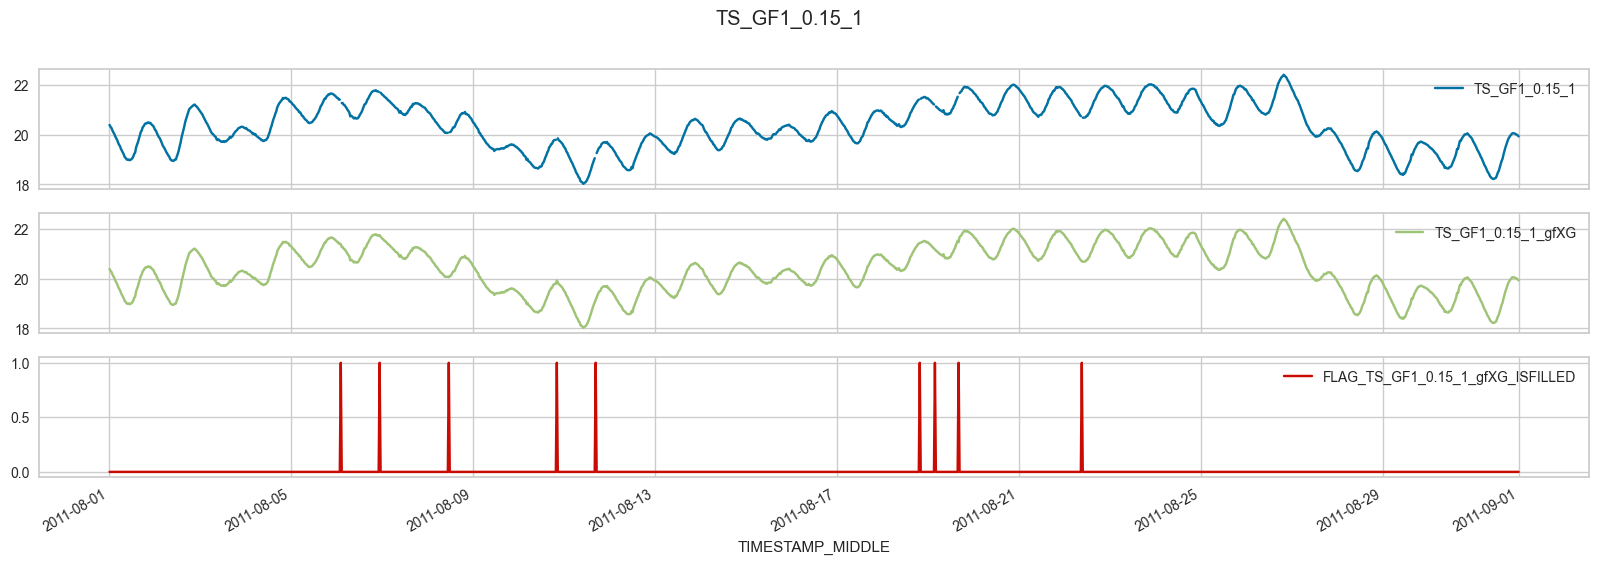

In [5]:
TARGET_COL = 'TS_GF1_0.15_1'
TARGET_GAPFILLED_COL = f'{TARGET_COL}_gfXG'
FLAG_GAPFILLED_COL = f'FLAG_{TARGET_GAPFILLED_COL}_ISFILLED'

# Dataframe for gap-filling
_df = pd.DataFrame()
_df[TARGET_COL] = df[TARGET_COL].copy()
_df['TS_GF1_0.04_1_gfXG'] = df['TS_GF1_0.04_1_gfXG'].copy()

# XGBoost
xgb = XGBoostTS(
    input_df=_df,
    target_col=TARGET_COL,
    features_lag=[-10, -1],
    features_lag_exclude_cols=None,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()
results = xgb.gapfilling_df_

# Add results to main data
df = pd.concat([df, results[[TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]]], axis=1)

# Plot
plotdf = df[[TARGET_COL, TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]].copy()
plotdf.plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));
locs = (plotdf.index.year == 2011) & (plotdf.index.month == 8)
plotdf[locs].plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));

## Fill `TS_GF1_0.4_1`


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.

Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-09-09 10:15:00 and 2023-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:3.85005	validation_1-rmse:3.84730
[1]	validation_0-rmse:2.71597	validation_1-rmse:2.71385
[2]	validation_0-rmse:1.92673	validation_1-rmse:1.92513
[3]	validation_0-rmse:1.38087	validation_1-rmse:1.37992
[4]	validation_0-rmse:1.00617	validation_1-rmse:1.00566
[5]	validation_0-rmse:0.75319	validation_1-rmse:0.75318
[6]	validation_0-rmse:0.58500	validation_1-rmse:0.58535
[7]	validation_0-rmse:0.47727	validation_1-rmse:0.47807
[8]	validation_0-rmse:0.40938	validation_1-rmse:0.41058
[9]	validation_0-rmse:0.36561	validation_1-rmse:0.36701
[10]	va

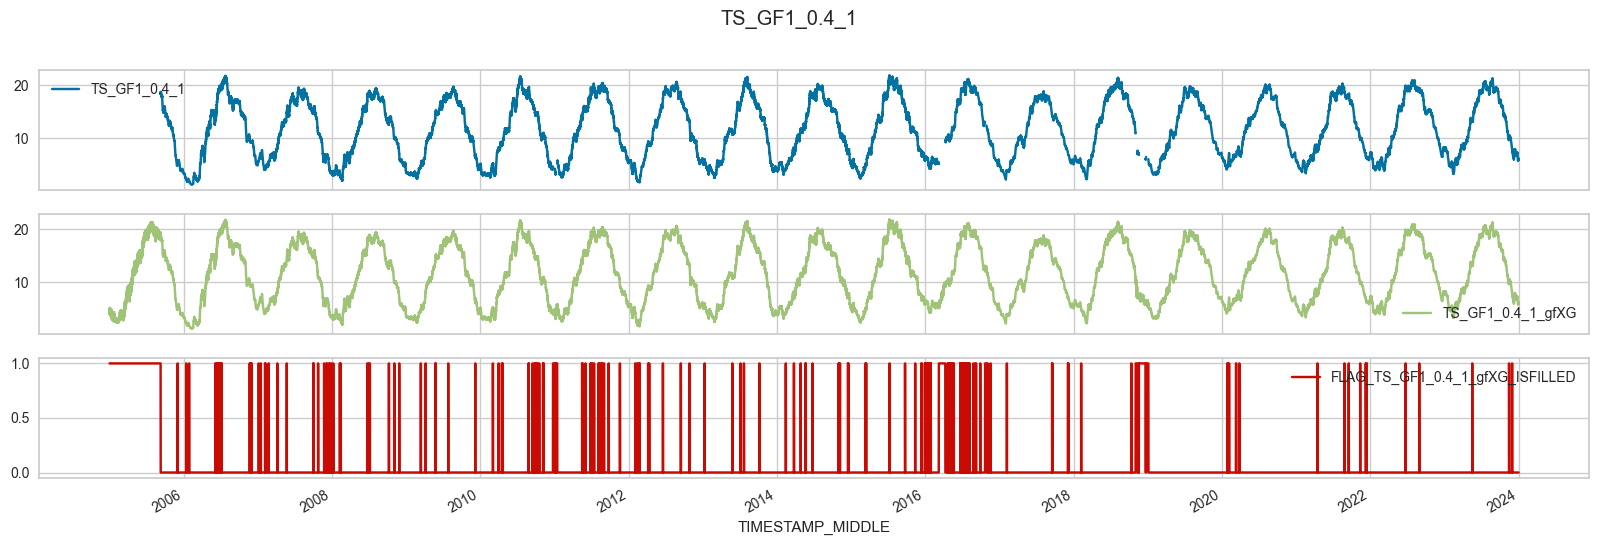

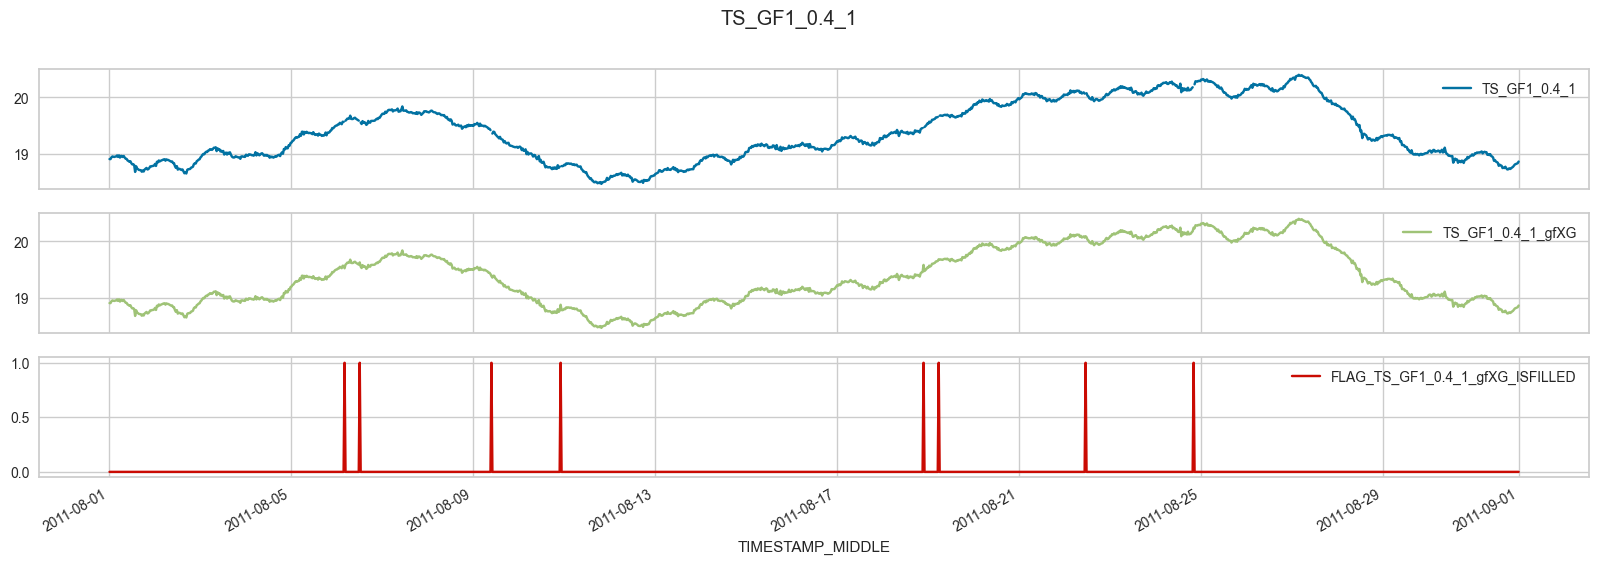

In [6]:
TARGET_COL = 'TS_GF1_0.4_1'
TARGET_GAPFILLED_COL = f'{TARGET_COL}_gfXG'
FLAG_GAPFILLED_COL = f'FLAG_{TARGET_GAPFILLED_COL}_ISFILLED'

# Dataframe for gap-filling
_df = pd.DataFrame()
_df[TARGET_COL] = df[TARGET_COL].copy()
_df['TS_GF1_0.04_1_gfXG'] = df['TS_GF1_0.04_1_gfXG'].copy()
_df['TS_GF1_0.15_1_gfXG'] = df['TS_GF1_0.15_1_gfXG'].copy()

# XGBoost
xgb = XGBoostTS(
    input_df=_df,
    target_col=TARGET_COL,
    features_lag=[-10, -1],
    features_lag_exclude_cols=None,
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()
results = xgb.gapfilling_df_

# Add results to main data
df = pd.concat([df, results[[TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]]], axis=1)

# Plot
plotdf = df[[TARGET_COL, TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]].copy()
plotdf.plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));
locs = (plotdf.index.year == 2011) & (plotdf.index.month == 8)
plotdf[locs].plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));

# Save to file

In [11]:
OUTNAME = "52.1_CH-CHA_IRGA-L4.1+QCL-L1+LGR-L1+M10+MGMT_2005-2023"
filepath = save_parquet(filename=OUTNAME, data=df)
df.to_csv(f"{OUTNAME}.csv")

Saved file 52.1_CH-CHA_IRGA-L4.1+QCL-L1+LGR-L1+M10+MGMT_2005-2023.parquet (7.585 seconds).


# **End of notebook**.

In [12]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-12-18 09:34:18
